In [36]:
import sys
sys.path.append('../')

import msgpack
import pandas as pd
from matplotlib import pyplot as plt
from collections import OrderedDict
from typing import Union, Dict
from gerador import pypsg

In [223]:
def converter_configuracao(configuracao: Union[Dict, str], para_dataframe: bool = True) -> Union[pd.DataFrame, str]:
    """
    Converte uma configuração de string para DataFrame ou vice-versa.

    Args:
        configuracao (Union[Dict, str]): Configuração a ser convertida.
        para_dataframe (bool, optional): Se True, converte para DataFrame. 
        Se False, converte para string.

    Raises:
        ValueError: Se o tipo de dado da configuração não for suportado para conversão.

    Returns:
        Union[pd.DataFrame, str]: Configuração convertida.
    """
    if isinstance(configuracao, str):
        if para_dataframe:
            config_dict = {chave.strip("<"): [valor.strip()] 
                           for linha in configuracao.split("\n") if linha.strip() 
                           for chave, valor in [linha.split(">", 1)]}
            return pd.DataFrame(config_dict)
        else:
            return configuracao
    elif isinstance(configuracao, dict):
        if para_dataframe:
            return pd.DataFrame.from_dict(configuracao, orient="index").T
        else:
            return "\n".join([f"<{chave}>{valor}" for chave, valor in configuracao.items()])
    else:
        raise ValueError("Tipo de dado não suportado para conversão")


class EspectroAnalise:
    """
    Classe base para análise de espectros.

    Esta classe fornece métodos para analisar espectros, incluindo a conversão de espectros para DataFrames pandas,
    a plotagem de espectros e a exibição de cabeçalhos de resultados de espectros.
    """
    
    def __init__(self, resultado: Dict):
        """
        Inicializa a classe com um resultado de espectro.
        
        Args:
            resultado (Dict): Um dicionário contendo o resultado do espectro.
        """
        self._resultado = resultado
        self._configurar_matplotlib()
    
    def _configurar_matplotlib(self):
        """
        Configura os parâmetros do matplotlib.
        """
        plt.rcParams.update({
            "axes.spines.right": False,
            "axes.spines.top": False,
            "font.size": 12,
            "axes.labelsize": 12,
            "axes.titlesize": 12,
            "legend.fontsize": 10,
            "xtick.labelsize": 10,
            "ytick.labelsize": 10,
            "figure.figsize" : (10, 4)
            })

    def mostrar_cabecalho(self):
        """
        Mostra o cabeçalho do resultado do espectro.

        Este método imprime o cabeçalho do resultado do espectro. Se nenhum cabeçalho estiver disponível,
        ele imprimirá "Nenhum cabeçalho disponível".
        """
        cabecalho = self._resultado.get("header", "Nenhum cabeçalho disponível")
        print(cabecalho)
    
    def converter_para_dataframe(self) -> pd.DataFrame:
        """
        Converte o espectro em um DataFrame pandas.
        
        Este método converte o espectro, que é uma lista de listas, em um DataFrame pandas. As colunas do DataFrame
        são "Wave/freq [um]", "Total [I/F apparent albedo]", "Noise", "Stellar", "Planet".
        
        Returns:
            pd.DataFrame: Um DataFrame contendo o espectro.
        """
        espectro = self._resultado.get("spectrum", [])     
        colunas = ["Wave/freq [um]", "Total [I/F apparent albedo]", "Noise", "Stellar", "Planet"]
        return pd.DataFrame(espectro, columns=colunas)
    
    def plotar_espectro(self, cor_linha = "tab:blue", cor_erro = "gray", mostrar_erro = True, ax = None, label = None):
        """
        Plota o espectro.

        Este método plota o espectro usando matplotlib. Ele plota "Wave/freq [um]" no eixo x 
        e "Total [I/F apparent albedo]" no eixo y. Ele também adiciona barras de erro usando a coluna 
        "Noise", se `mostrar_erro` for True.

        Args:
            cor_linha (str, optional): Cor da linha do gráfico. Padrão é "tab:blue".
            cor_erro (str, optional): Cor das barras de erro. Padrão é "gray".
            mostrar_erro (bool, optional): Se True, mostra as barras de erro. Se False, não mostra. Padrão é True.
            ax (matplotlib.axes._axes.Axes, optional): Eixo em que o gráfico será plotado. Se None, cria um novo eixo. Padrão é None.
            label (str, optional): Rótulo do gráfico para a legenda. Padrão é None.
            
        Returns:
            matplotlib.axes._axes.Axes: O eixo onde o gráfico foi plotado.
        """
        espectro_df = self.converter_para_dataframe()
        wave_freq = espectro_df["Wave/freq [um]"]
        total_albedo = espectro_df["Total [I/F apparent albedo]"]
        erro = espectro_df["Noise"] if mostrar_erro else None

        if ax is None:
            _, ax = plt.subplots()

        ax.plot(wave_freq, total_albedo, color=cor_linha, lw=2, label=label)

        if mostrar_erro:
            ax.errorbar(wave_freq, total_albedo, yerr=erro, fmt="o", capsize=3, 
                         color=cor_erro, alpha=0.35, markersize=5)
        
        ax.set(xlabel = "Comprimento de onda [$\mu$m]", ylabel = "Albedo aparente")

        return ax

def modifica_valor_gas(dicionario, gas, multiplicador):
    """
    Modifica os valores de gás em um dicionário ordenado.

    Args:
        ordered_dict (dict): O dicionário ordenado contendo os valores de gás.
        gas (str): O gás a ser modificado: 'H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 
        'NH3', 'HNO3', 'OH','HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2',
        'C2H2', 'C2H6', 'PH3'
        multiplier (float): O fator pelo qual multiplicar o valor do gás.

    Returns:
        None: O dicionário ordenado é modificado in-place.
    """
    indice_gas = None
    elementos = ['H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 'NH3', 'HNO3', 'OH', 
                 'HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2', 
                 'C2H2', 'C2H6', 'PH3']
    try:
        indice_gas = elementos.index(gas)
    except ValueError:
        print("Gás não encontrado na lista de elementos.")
        return

    for key, value in dicionario.items():
        if key.startswith("ATMOSPHERE-LAYER-"):
            values = value.split(',')
            values[indice_gas + 2] = str(float(values[indice_gas + 2]) * multiplicador)
            dicionario[key] = ','.join(values)

def modifica_pressao_atmosferica(dicionario, valor):
    """
    Modifica o valor da pressão atmosférica.

    Args:
        dicionario (dict): O dicionário ordenado.
        valor (float): O novo valor da pressão atmosférica em mbar.

    Returns:
        None: O dicionário ordenado é modificado in-place.
    """
    for key, _ in dicionario.items():
        if key == "ATMOSPHERE-PRESSURE":
            dicionario[key] = str(valor)
            return

## Primeiro Teste - Carregando arquivo de configuração do HWO para Terra moderna

In [132]:
with open("../gerador/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))

config_df = converter_configuracao(config)
config_df

,OBJECT,OBJECT-NAME,OBJECT-DATE,OBJECT-DIAMETER,OBJECT-GRAVITY,OBJECT-GRAVITY-UNIT,OBJECT-STAR-DISTANCE,OBJECT-STAR-VELOCITY,OBJECT-SOLAR-LONGITUDE,OBJECT-SOLAR-LATITUDE,...,GENERATOR-RADUNITS,GENERATOR-RESOLUTIONKERNEL,GENERATOR-TRANS,OBJECT-ORBIT,OBJECT-POSITION-ANGLE,ATMOSPHERE-AEROS,ATMOSPHERE-ATYPE,ATMOSPHERE-AABUN,ATMOSPHERE-AUNIT,ATMOSPHERE-ASIZE
0,Exoplanet,Exoplanet,2017/12/22 15:09,12742,9.807,g,0.9837,0.0,102.9,0.02,...,rif,N,02-01,"0.00000000,0.00000,0.00000000,0.00000,0.98370,...",0.0,,,,,


In [222]:
config_df["ATMOSPHERE-PUNIT"]

0    mbar
Name: ATMOSPHERE-PUNIT, dtype: object

In [5]:
psg = pypsg.PSG(server_url="https://psg.gsfc.nasa.gov/api.php", timeout_seconds = 20)
resultado = psg.run(config)

Testing connection to PSG at https://psg.gsfc.nasa.gov/api.php ...
Connected to PSG with success.


In [200]:
spectrum = EspectroAnalise(resultado)
spectrum.mostrar_cabecalho()

# ------------------------------------------------------------------------
# Radiance spectrum
# NASA-GSFC Planetary Spectrum Generator (PSG) (Villanueva et al. 2018, 2022)
# Synthesized on Tue Apr  2 15:39:52 2024
# Doppler velocities [km/s] (vobs,vrot+vorb,vwidth,vrfl,vstr): 0.00000,0.00000,0.00000,0.00000,-0.00000
# ------------------------------------------------------------------------
# Spectra synthesized with the Planetary and Universal Model of Atmospheric Scattering (PUMAS, Villanueva et al. 2018, 2022)
# Muliple scattering method employing PSGDORT, NMAX:1 / LMAX:2 / gMAX:0.00
# ------------------------------------------------------------------------
# Spectral unit: Wavelength [um]
# Radiance unit: I/F [apparent albedo]
# Wave/freq Total Noise Stellar Exoplanet


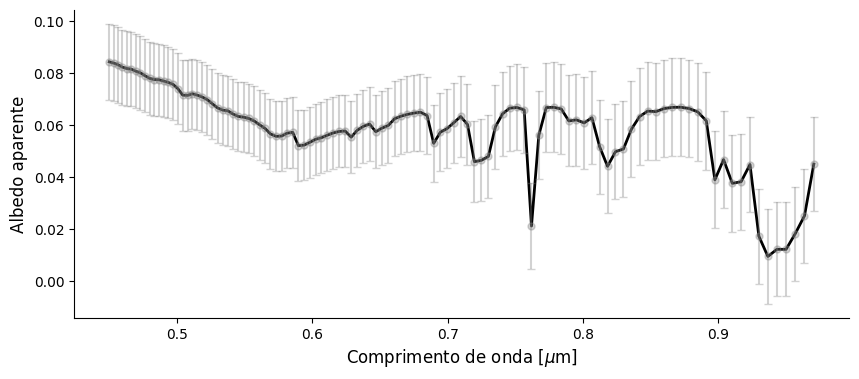

In [239]:
spectrum.plotar_espectro(cor_linha = "k");

## Teste 2 - Mudando as abundâncias

In [202]:
# Dobrando o valor de O2
config_dobro_O2 = config.copy()
modifica_valor_gas(config_dobro_O2, "O2", 2)
resultado_dobro_O2 = psg.run(config_dobro_O2)

In [203]:
# Tirando O2 da atmosfera
config_sem_O2 = config.copy()
modifica_valor_gas(config_sem_O2, "O2", 0)
resultado_sem_O2 = psg.run(config_sem_O2)

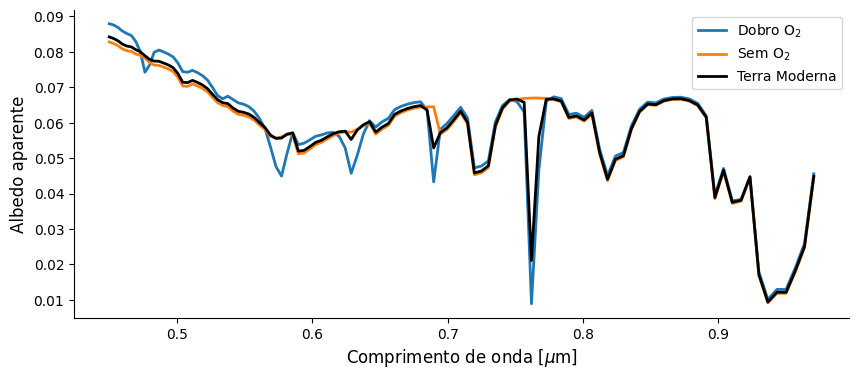

In [240]:
spectrum_dobro_02 = EspectroAnalise(resultado_dobro_O2)
spectrum_sem_02 = EspectroAnalise(resultado_sem_O2)

fig, ax = plt.subplots()
ax = spectrum_dobro_02.plotar_espectro(ax = ax, label = "Dobro O${}_2$", mostrar_erro = False, cor_linha = "tab:blue")
ax = spectrum_sem_02.plotar_espectro(ax = ax, label = "Sem O${}_2$", mostrar_erro = False, cor_linha = "tab:orange")
ax = spectrum.plotar_espectro(ax=ax, label="Terra Moderna", mostrar_erro = False, cor_linha = "k")
ax.legend();

## Teste 3 - Modificando a pressão atmosférica (mbar)

In [227]:
# 500 mbar = .5 bar
# O espectro não retornou nada para o dobro e 4x a pressão atmosférica
config_metade_atm = config.copy()
modifica_pressao_atmosferica(config_metade_atm, 500)
resultado_metade_atm = psg.run(config_metade_atm)

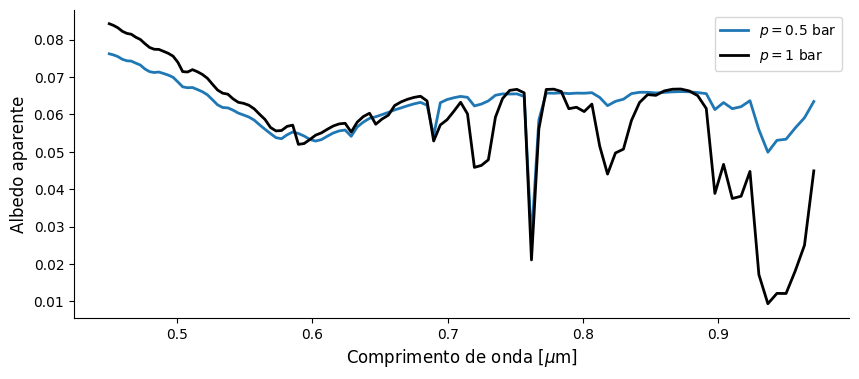

In [237]:
spectrum_metade_atm = EspectroAnalise(resultado_metade_atm)

fig, ax = plt.subplots()
ax = spectrum_metade_atm.plotar_espectro(ax = ax, label = "$p = 0.5$ bar", mostrar_erro = False, cor_linha = "tab:blue")
ax = spectrum.plotar_espectro(ax=ax, label = "$p = 1$ bar", mostrar_erro = False, cor_linha = "black")
ax.legend();

## TODO

- Esses espectros fazem sentido físico? NÃO
- todos os mixing ratios constante não fazem sentido!
- Adicionar perfis do arqueno - DEPOIS DO PRIMEIRO TREINO



- modificar partes separadamente (ver o PT constante, e ir aos poucos)
- testar um df no PICASO  (COM MEU CÓDIGO)

- Modificar o conf só com os compostos
- Pressão atmosférica na superfície (bar): 0.5, 1, 2, 4

- Aumentando a complexidade aos poucos

Teste da Terra atual:

- Primeiro teste: gerar o espectro da Terra atual com o seu código para obter o mesmo grafico do PSG
- Segundo teste: mudar apenas a abundancia, multiplicando alguns valores de mixing ratio (por exemplo, multiplicar O2 por 2x ou 0.5)
- Terceiro teste: mudar a pressao atmosférica (ao inves de 1 bar, usar 0.5bar, por exemplo)